In [30]:
import os
import platform 
import gc

import re
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = None


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb

import warnings 
warnings.filterwarnings('ignore')

In [31]:
X = pd.read_csv('./input/train_data.csv')
X_test = pd.read_csv('./input/test_data.csv')
test_id = X_test['id']

In [32]:
y = X['salary']
X = X.drop(['salary', 'id'], axis=1)
X_test = X_test.drop(['id'], axis=1)

In [33]:
X.dtypes

position            int64
age                 int64
area               object
sex                 int64
partner             int64
num_child           int64
education           int64
service_length      int64
study_time        float64
commute           float64
overtime          float64
dtype: object

In [35]:
X = X.astype({'position':object, 'sex': object, 'partner': object, 'education': object})
X_test = X_test.astype({'position':object, 'sex': object, 'partner': object, 'education': object})

In [36]:
X.dtypes

position           object
age                 int64
area               object
sex                object
partner            object
num_child           int64
education          object
service_length      int64
study_time        float64
commute           float64
overtime          float64
dtype: object

# Feature Engineering

In [37]:
def create_feature(df):
    #position-age
    df['MA'] = df['age'].apply(lambda x: 1 if (x >= 26) else 0)
    df['GM'] =  df['age'].apply(lambda x: 1 if (x >= 31) else 0)
    df['not_noname'] = df['age'].apply(lambda x: 1 if (x <= 31) else 0)
    
    df['position_age'] = 0
    df['position_age'][(df['age'] >=18) & (df['age'] <=25)] = 0
    df['position_age'][(df['age'] >=26) & (df['age'] <=31)] = 1
    df['position_age'][(df['age'] >=32) & (df['age'] <=36)] = 2
    df['position_age'][(df['age'] >=37)& (df['age'] <=58)] = 3
    df['position_age'][(df['age'] >=59)] = 4
    return df

In [38]:
X = create_feature(X)
X_test = create_feature(X_test)

## Labeling

In [39]:
def labeling(X, X_test, y):
    col_category = []
    for i in X.columns:
        if X[i].dtype == 'object':
            
            # ======== ラベルエンコーディング ==========
            le = LabelEncoder()
            X[f'{i}_label'] = le.fit_transform(X[i])
            X_test[f'{i}_label'] = le.transform(X_test[i])
            
            col_category.append(f'{i}_label')
            
            
            # ========= ランキング ==============
            maps = pd.concat([X, np.exp(y)], axis=1).groupby(i)['salary'].mean().sort_values(ascending=False).index
            maps = pd.DataFrame({i: maps, 'rank': np.linspace(0, maps.shape[0]-1, maps.shape[0])})
            maps = dict(maps.to_dict(orient='split')['data'])
            X[f'{i}_rank'] = X[i].map(maps)
            X_test[f'{i}_rank'] = X_test[i].map(maps)
            
            col_category.append(f'{i}_rank')
            
            
            # ===== targeting =======
            data_tmp = pd.DataFrame({i:X[i], 'target':y})
            target_mean = data_tmp.groupby(i)['target'].mean()
            
            X_test[f'{i}_target'] = X_test[i].map(target_mean)
            #X_test[f'{c}_target_log'] = np.log(X_test[c].map(target_mean))
            
            tmp = np.repeat(np.nan, X.shape[0])
            
            kf = KFold(n_splits=4, shuffle=True, random_state=72)
            
            for idx_1, idx_2 in kf.split(X):
                target_mean = data_tmp.iloc[idx_1].groupby(i)['target'].mean()
                tmp[idx_2] = X[i].iloc[idx_2].map(target_mean)
                X[f'{i}_target'] = tmp
                #X[f'{c}_target_log'] = np.log(tmp)
            
            col_category.append(f'{i}_target')
            #new_col_category.append(f'{c}_target_log')
            
            # ===== 元のラベルの削除 =====
            X = X.drop(i, axis=1)
            X_test = X_test.drop(i, axis=1)
            
    return X, X_test, col_category

In [40]:
X, X_test, col_category = labeling(X, X_test, y)

In [41]:
print('X.shape', X.shape,
      '\nX_test.shape', X_test.shape,
     )

X.shape (21000, 25) 
X_test.shape (9000, 25)


In [42]:
X.head()

,age,num_child,service_length,study_time,commute,overtime,MA,GM,not_noname,position_age,position_label,position_rank,position_target,area_label,area_rank,area_target,sex_label,sex_rank,sex_target,partner_label,partner_rank,partner_target,education_label,education_rank,education_target
0,44,2,24,2.0,1.6,9.2,1,1,0,3,1,3.0,353.052757,24,36.0,394.344582,1,0.0,356.000041,1,0.0,386.011628,1,3.0,324.580923
1,31,0,13,9.0,0.7,12.4,1,1,1,1,2,2.0,464.199322,10,11.0,369.951268,0,1.0,364.886034,0,1.0,335.696862,0,4.0,309.005587
2,36,0,14,4.0,0.4,16.9,1,1,0,2,2,2.0,464.577931,14,8.0,357.888184,0,1.0,366.979616,0,1.0,337.331617,2,2.0,384.643186
3,22,0,4,3.0,0.4,6.1,0,0,1,0,0,4.0,220.888384,26,44.0,406.042014,1,0.0,355.623862,0,1.0,335.696862,0,4.0,309.005587
4,25,0,5,3.0,0.2,4.9,0,0,1,0,0,4.0,220.888384,46,0.0,351.506991,1,0.0,355.623862,0,1.0,335.696862,1,3.0,324.608579


In [43]:
y = np.log(y)

In [44]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 255,
    'max_bin': 255,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
}

In [45]:
def lightgbms(X, X_test, y, params, random=0):
    
    NFOLDS = 5
    
    folds = KFold(n_splits=NFOLDS, random_state=random, shuffle=True)

    preds = pd.DataFrame()
    train_preds = pd.DataFrame()

    columns = X.columns
    splits = folds.split(X, y)

    y_preds = np.zeros(X_test.shape[0])
    y_oof = np.zeros(X.shape[0])

    score = 0
    scores = []

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = columns

    for fold_n, (train_index, val_index) in enumerate(splits):
        # split train, Valid
        X_train, X_val = X[columns].iloc[train_index], X[columns].iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        '''
        LightGBM
        '''
        dtrain = lgb.Dataset(X_train, y_train)
        dval = lgb.Dataset(X_val, y_val)

        clf = lgb.train(params,
                        dtrain,
                        5000,
                        valid_sets=[dtrain, dval],
                        verbose_eval=1000,
                        categorical_feature=col_category,
                        early_stopping_rounds=500)
        
        
        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        
        '''
        LightGBM
        '''
        # stack
        y_pred_val = clf.predict(X_val)
        y_oof[val_index] = y_pred_val
    
            
        print(f"Fold {fold_n + 1} | rmse: {mean_absolute_error(np.exp(y_val),np.exp( y_pred_val))}")
        
        score += mean_absolute_error(np.exp(y_val),np.exp( y_pred_val)) / NFOLDS
        scores.append(mean_absolute_error(np.exp(y_val),np.exp( y_pred_val)))

        y_preds += clf.predict(X_test) / NFOLDS

        train_preds[f"Fold {fold_n + 1}"] = clf.predict(X)

        preds[f"Fold {fold_n + 1}"] = clf.predict(X_test)

        del X_train, X_val, y_train, y_val
        gc.collect()
    print(f"\nMean RSME = {score}")

    return y_oof, y_preds, scores, feature_importances

In [46]:
%%time
## === Seed ===
_, y_preds1, _, feature_importances = lightgbms(X, X_test, y, params, 1)
_, y_preds2, _, _ = lightgbms(X, X_test, y, params, 2)
_, y_preds3, _, _ = lightgbms(X, X_test, y, params, 3)
_, y_preds4, _, _ = lightgbms(X, X_test, y, params, 4)
_, y_preds5, _, _ = lightgbms(X, X_test, y, params, 5)

Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.000970101	valid_1's fair: 0.00398854
Early stopping, best iteration is:
[679]	training's fair: 0.00142838	valid_1's fair: 0.00396157
Fold 1 | rmse: 25.088993396402724
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.000962594	valid_1's fair: 0.00417051
Early stopping, best iteration is:
[568]	training's fair: 0.00165241	valid_1's fair: 0.00412882
Fold 2 | rmse: 25.056821411303368
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.000979045	valid_1's fair: 0.00373246
Early stopping, best iteration is:
[610]	training's fair: 0.00158508	valid_1's fair: 0.00369599
Fold 3 | rmse: 23.8547205852445
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.000973871	valid_1's fair: 0.00384043
Early stopping, best iteration is:
[589]	training's fair: 0.00161984	valid_1's fair: 0.00380553
Fold 4 | rms

In [47]:
pred_list = [y_preds1,
             y_preds2,
             y_preds3,
             y_preds4,
             y_preds5]
pred = np.zeros(X_test.shape[0])
for i in pred_list:
    pred += np.exp(i).astype(int) / 5
    
pred = pred.astype(int)

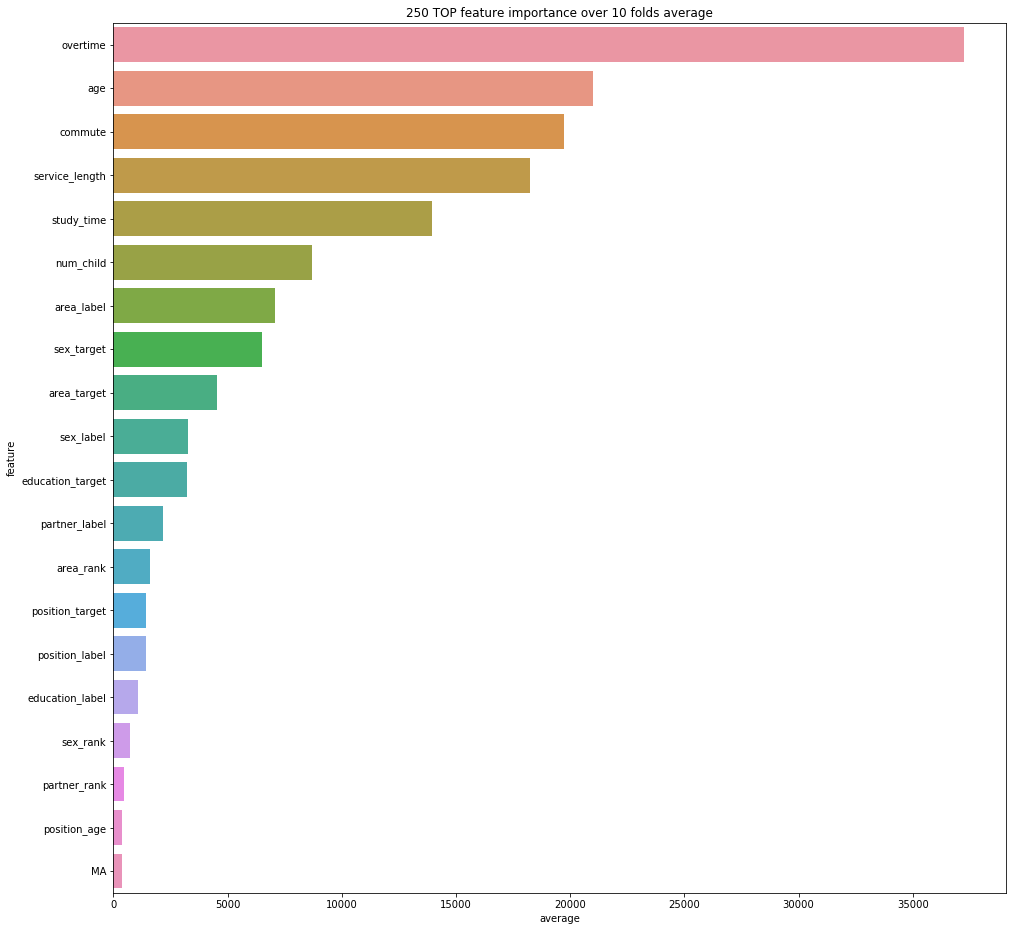

In [48]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(5)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('250 TOP feature importance over {} folds average'.format(10))
#plt.savefig('TOP250_feature_importance.png')
plt.show()

In [50]:
sub = pd.DataFrame({'id': test_id, 'y': pred})

In [51]:
sub.head()

,id,y
0,0,514
1,1,293
2,2,207
3,3,159
4,4,294


In [52]:
sub.to_csv('sub_lgb_second.csv', index=None)